# Gyakorlat 3
## Logisztikus regresszió:
### Egyetemi felvételi:

Ebben a feladatban logisztikus regressziót fogunk használni, hogy megjósoljuk egy adott hallgató felvételének tényét az egyetemre.

Tegyük fel, hogy egyetemi adminisztrátorok vagyunk és meg szeretnénk határozni,  egy adott jelentkezőnek az esélyét a sikeres felvételire a két felvételi teszt eredménye alapján. Rendelkezésünkre állnak az eddigi eredmények címkézve, hogy az adott hallgató jelentkezése sikeres volt vagy nem.

Ezt az adathallmazt tudjuk használni a logisztikus regressziónkra.

### Importáljuk be a megfelelő csomagokat:
Szükségünk lesz:
- NumPy
- MatPlotLib pyplopt csomagjára
- Pandas csomagot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Olvassuk be az adatainkat!

In [2]:
data = pd.read_csv('Lab3data.txt', header = None).to_numpy()
X = data[:,0:2]
m,n = X.shape                         # m adatok száma / n feature-k száma
Y = data[:,2].reshape(m,1)
del data

print('X:', X.shape)
print('Y:', Y.shape)
print('Adatok száma:',m)
print('Feature-ök száma:',n)

X: (100, 2)
Y: (100, 1)
Adatok száma: 100
Feature-ök száma: 2


### Jelenítsük meg az adatainkat!

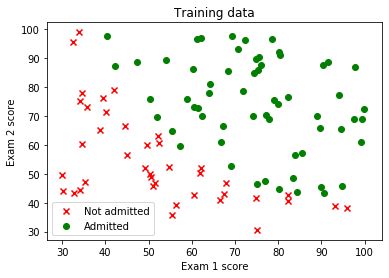

In [3]:
def plotData(X,Y):
    pos=[]
    neg=[]

    for i in range(0,Y.size):
        if Y[i] ==0:
            neg.append(X[i,:])
        elif Y[i] ==1:
            pos.append(X[i,:])

    neg = np.array(neg)
    pos = np.array(pos)

    plt.scatter(neg[:,0],neg[:,1],marker='x',c="r", label="Not admitted")
    plt.scatter(pos[:,0],pos[:,1],marker='o',c="g", label="Admitted")
    plt.title("Training data")
    plt.xlabel("Exam 1 score")
    plt.ylabel("Exam 2 score")
    plt.legend(loc='lower left')
    plt.show()

    return pos, neg

pos,neg=plotData(X,Y)

Láthatjuk, hogy a két kategória elválasztható megközelítőleg egy egyenessel.

### Bias hozzáadása az X mátrixhoz:

In [4]:
if (X.shape[1]==2):
    X=np.column_stack((np.ones((m,1)),X))       # bias
#EZT CSAK EGYSZER SZABAD LEFUTTATNI! VAGY ÚJRA KELL A KERNELT INDÍTANI

## A model:

A hipotézisünkre használjuk az alábbi modelt:
$ h_w(x) = g(XW) $ , ahol $ g(z) = \frac{1}{1+e^{-z}} $

Ehhez szükségünk lesz egy szigmoid függvény definiálására.

# IDE MÉG ELMÉLETI RIZSA!!!!

### Sigmoid függvény definíció:
A szigmoid függvény definíciója: $ g(z) = \frac{1}{1+e^{-z}} $ \
Hozzuk létre a sigmoid nevű függvényt, majd teszteljük is az eredményt 0, 0.5, 1 értékekre!

In [5]:
def sigmoid(z):
    # calculates the sigmoid function value
    return 1/(1 + np.exp(-z))

print('Függvény érték 0 bemenőértékre',sigmoid(0))
print('Függvény érték 0.5 bemenőértékre',sigmoid(0.5))
print('Függvény érték 1 bemenőértékre',sigmoid(1))

Függvény érték 0 bemenőértékre 0.5
Függvény érték 0.5 bemenőértékre 0.6224593312018546
Függvény érték 1 bemenőértékre 0.7310585786300049


### A költségfüggvény:

Költségfüggvényként használjuk az alábbi összefüggést:

$ C(w) = -\frac{1}{m} \sum{y^i\cdot\log(h_w(x^i))-(1-y^i)\cdot\log(1-h_w(x^i))} $

Azért kell változtatnunk a költségfüggvényen, hogy az szép konvex legyen. Ez által az optimalizálás is gyorsabb lesz.

### A gárdiens függvény:
A költségfüggvényt lederiválva itt is a grádiens függvényét kapjuk:
$grad = \frac{X^T \cdot (h_w(X)-Y)}{m}$

# ELMÉLETI RIZSA IDE!!!!!


### costFunction definiálása:
Írjuk meg a costFunction definícióját, majd teszteljük le két w értékkel!\
Az inital_w legyen [0; 0; 0], míg test_w legyen [-24; 0.2; 0.2]!

In [ ]:
def costFunction(w,X,Y):
    prediction = np.array(sigmoid(X@w))
    error = ((-Y) * np.log(prediction)) - ((1-Y)*(np.log(1-prediction)))
    C = (1/m) * np.sum(error)

    grad = (X.transpose())@(prediction-Y)/m

    return C, grad

initial_w = np.zeros(((n+1),1))
C,grad = costFunction(initial_w,X,Y)

print('''Cost and Gradient  at initial weights (zeros):
Expected cost (approx.): 0.693
Computed:''',C)
print('''Expected gradient(approx.):
 [[-0.1]
 [-12.0092]
 [-11.2628]]
Computed:\n''',grad)

test_w = np.array([[-24], [0.2], [0.2]])
C, grad = costFunction(test_w,X,Y)

print('\nTest weights:',test_w.transpose())
print('''Cost and Gradient  at test weights:
Expected cost (approx.): 0.218
Computed:''',C)
print('''Expected gradient(approx.):
 [[0.043]
 [2.566]
 [2.647]]
Computed:\n''',grad)
print('\n')

### Feature normalization:

In [ ]:
def featureNormalization(X):
    mean = np.mean(X,axis=0)
    std = np.std(X, axis=0,ddof=1)
    X_temp = X.copy()

    if std[0] == 0:
        X_temp=np.delete(X_temp,0,1)
        X_norm = (X_temp - mean[1:3]) / std[1:3]
        X_norm=np.column_stack((np.ones((m,1)),X_norm))
    else:
        X_norm = (X_temp - mean) / std

    return X_norm,mean,std

X_norm,mean,std=featureNormalization(X)

### Grádiens módszer definiálása:

In [ ]:
def gradientDescent(X,Y,w,alpha,num_iters=400):
    C_history = []

    for i in range(num_iters):
        C, grad = costFunction(w,X,Y)
        w = w - (alpha*grad)
        C_history.append(C)

    return w, np.array(C_history)

### Grádiens módszer kirpóbálása több tanulási rátára:

In [ ]:
w = np.array([[0],[0],[0]])
w, C_history = gradientDescent(X_norm,Y,w,0.01)
plt.plot(range(C_history.size), C_history, label= "learning r.:0.01 / iters.: 400")

w = np.array([[0],[0],[0]])
w, C_history = gradientDescent(X_norm,Y,w,0.1)
plt.plot(range(C_history.size), C_history, label= "learning r.:0.1 / iters.: 400")

w = np.array([[0],[0],[0]])
w, C_history = gradientDescent(X_norm,Y,w,1)
plt.plot(range(C_history.size), C_history, label= "learning r.:1 / iters.: 400")
plt.title("Effect of the different constants on the cost function")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
plt.legend()
plt.show()

In [ ]:
print('''The cost function at found weights by the gradient descent alg.:
Expected (approx): 0.203
Computed: ''', C_history[-1])
print('''Weights expected (approx.):
[1.659 3.867 3.603]
Weights computed:\n''', w.transpose())

### Kirajzoljuk a döntési határt

In [ ]:
pos_norm=(pos-mean[1:3])/std[1:3]
neg_norm=(neg-mean[1:3])/std[1:3]

plt.scatter(pos_norm[:,0],pos_norm[:,1],c="g", marker="o",label="Admitted")
plt.scatter(neg_norm[:,0],neg_nom[:,1],c="r",marker="x",label="Not admitted")
x_value = np.array([np.min(X_norm[:,1]),np.max(X_norm[:1])])
y_value = -(w[0]+w[1]*x_value)/w[2]
plt.plot(x_value,y_value,"k")
plt.title("Decision boundary and the training data")
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(loc=0)
plt.show()

### Előrejelzés:

In [ ]:
def predictionMaking(X):
    X = (X-mean[1:3])/std[1:3]
    X = np.append(np.ones((1)),X)
    return sigmoid(X@w)

prediction=predictionMaking(np.array([45,85]))
print('''Expected result of the prediction with [45 , 85] (approx.):
0.776291
Calculated:\n''',prediction)

### Pontosság:

In [ ]:
def calculateAccuracy(w,X,Y):
    predictions= (sigmoid(X@w)>0.5)
    percentage=(sum(predictions==Y)/m)*100
    return percentage

print(calculateAccuracy(w,X_norm,Y), '% accuracy (89 % expected)')